# Assignment 9 - Exercise 3
### Due July 2 at 14:00

**This notebook contains interactive widgets. 
They work on the standard editors *jupyter-notebook* and *jupyter-lab*, but we have no experience for other editors.**

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

## Exercise 3: Similarity Graphs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed
import ipywidgets as widgets

from numpy.testing import assert_equal, assert_almost_equal
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import sklearn.neighbors
import scipy.sparse.csgraph

In [2]:
# Generate the two moons datasets
n_samples = 100
X_moons, y_moons = make_moons(n_samples=n_samples, noise=0, shuffle=False, random_state=42)
X_noisy_moons, y_noisy_moons = make_moons(n_samples=n_samples, noise=0.15, shuffle=False, random_state=42)

# Shuffle points inside each class
_ = np.random.shuffle(X_moons[:int(n_samples/2)]), np.random.shuffle(X_moons[int(n_samples/2):])
_ = np.random.shuffle(X_noisy_moons[:int(n_samples/2)]), np.random.shuffle(X_noisy_moons[int(n_samples/2):])

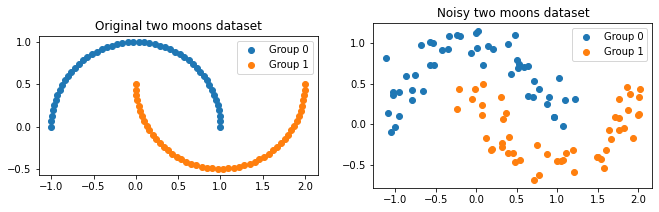

In [3]:
# Visualize the datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], label='Group 0')
ax1.scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], label='Group 1')
ax1.set_title('Original two moons dataset')
ax1.legend()
ax1.set_aspect('equal')

ax2.scatter(X_noisy_moons[y_noisy_moons==0, 0], X_noisy_moons[y_noisy_moons==0, 1], label='Group 0')
ax2.scatter(X_noisy_moons[y_noisy_moons==1, 0], X_noisy_moons[y_noisy_moons==1, 1], label='Group 1')
ax2.set_title('Noisy two moons dataset')
ax2.legend()
ax2.set_aspect('equal')

plt.show()

### (a) 
Implement  the  function `plot_similarities(X, sigma)` to  compute  the  paired  similarities with a Gaussian kernel and show them as a heat map.

In [4]:
def plot_similarities(X, sigma):
    ''' 
    Plot the paired similarities with a Gaussian kernel,
    by using a heat map.
        
    Parameters
    ----------
    X: input matrix
    sigma: kernel parameter
    '''
    ed = euclidean_distances(X) ** 2
    K = np.exp(- ed / (2 * sigma ** 2))
    
    plt.figure()
    plt.imshow(K)
    plt.title('Heatmap of similarity values')
    plt.gca().set_aspect('equal')
    plt.show()

In [5]:
sigma_props = dict(min=-2, max=2, step=0.1, value=10**.5, continuous_update=False)

interact(plot_similarities, X=fixed(X_moons), sigma=widgets.FloatLogSlider(**sigma_props));
interact(plot_similarities, X=fixed(X_noisy_moons), sigma=widgets.FloatLogSlider(**sigma_props));

interactive(children=(FloatLogSlider(value=3.1622776601683795, continuous_update=False, description='sigma', m…

interactive(children=(FloatLogSlider(value=3.1622776601683795, continuous_update=False, description='sigma', m…

- **Which values of $\sigma$ would you choose, and why?**

    <font color="blue">We would choose $\sigma = 0.25$ because it densely connects same-class data points while sparsely connecting data points from differenct classes.</font>
    
    
- **What is the role of noise, how does it influence your choice of $\sigma$?**

    <font color="blue">In this case, the noise parameter increases edges between data points from different classes. As a consequence, we have to choose a smaller value for $\sigma$.</font>


### (b) 
Now implement the function `plot_graph(X, k, mutual)`, which uses `sklearn.neighbors.kneighbors_graph` to create a graph and plots the adjacency matrix. Based on the parameter `mutual`, the graph should be either symmetric or mutual.

In [6]:
def unbalanced_gaussian(n_samples = 100, n_dimension = 200, ratio=0.2):
    """ Generate unbalanced Gaussian dataset """
    n_class_0 = int(n_samples * ratio)

    png = np.random.RandomState(42)
    X_unb_gaussian = png.normal(0, .6, size=(n_samples, n_dimension))
    X_unb_gaussian[:n_class_0, :2] -= 1.1
    X_unb_gaussian[n_class_0:, :2] += 1.

    y_unb_gaussian = np.zeros((n_samples, ))
    y_unb_gaussian[:n_class_0] = 0
    y_unb_gaussian[n_class_0:] = 1
    
    return X_unb_gaussian, y_unb_gaussian

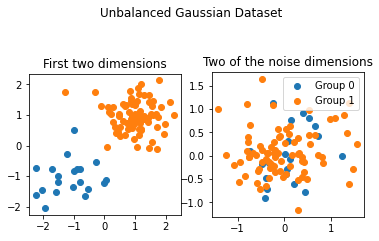

In [7]:
# Visualize the Gaussian datasets
X_unb_gaussian, y_unb_gaussian = unbalanced_gaussian(n_dimension=200)

plt.subplot(121, aspect='equal')
plt.scatter(X_unb_gaussian[y_unb_gaussian==0, 0], X_unb_gaussian[y_unb_gaussian==0, 1], label='Group 0')
plt.scatter(X_unb_gaussian[y_unb_gaussian==1, 0], X_unb_gaussian[y_unb_gaussian==1, 1], label='Group 1')
plt.title('First two dimensions')

plt.subplot(122, aspect='equal')
plt.scatter(X_unb_gaussian[y_unb_gaussian==0, 2], X_unb_gaussian[y_unb_gaussian==0, 3], label='Group 0')
plt.scatter(X_unb_gaussian[y_unb_gaussian==1, 2], X_unb_gaussian[y_unb_gaussian==1, 3], label='Group 1')
plt.title('Two of the noise dimensions')

plt.suptitle('Unbalanced Gaussian Dataset')
plt.legend()

plt.show()

In [8]:
def plot_graph(X, k=3, dim=2, mutual='symmetric'):
    ''' 
    Plot the adjacency matrix of a graph created 
    by using the function kneighbors_graph of sklearn.neighbors.
        
    Parameters
    ----------
    X: input matrix (n, d)
    k: number of neighbors for each sample
    dim: number of dimensions to use
    mutual: parameter for choosing mutual kNN or symmetric kNN
    '''
    
    # A is the adjancency matrix (n, n)
    A = np.zeros((X.shape[0], X.shape[0]))
    X = X[:, :dim]
    
    # fill and plot adjacency matrix
    plt.subplot(121, aspect='equal')
    
    A = sklearn.neighbors.kneighbors_graph(X, n_neighbors=k).A
    
    if mutual == 'mutual':
        A = (A + A.T > 0)

    plt.imshow(A)
    
    # A is the adjancy matrix (n, n)
    n_connected, _ = scipy.sparse.csgraph.connected_components(A)
    plt.title('Adjacency Matrix '.format(mutual, ))

    # plot  connections
    plt.subplot(122, aspect='equal')
    for x, a in zip(X, A):
        for y in X[a.astype(bool)]:
            plt.plot([x[0], y[0]], [x[1], y[1]], c='r')
    plt.plot(X[:, 0], X[:, 1], '.', zorder=10)
    plt.title('#Connected Components: {}'.format(n_connected))
    plt.suptitle('{} kNN Graph'.format(mutual.capitalize()))
    
    plt.show()

In [9]:
k_props = dict(min=1, max=50, continuous_update=False)
dim_props = dict(min=2, max=200, step=2, continuous_update=False)

interact(plot_graph, X=fixed(X_unb_gaussian), mutual=fixed('mutual'), k=widgets.IntSlider(**k_props), dim=widgets.IntSlider(**dim_props))
interact(plot_graph, X=fixed(X_unb_gaussian), mutual=fixed('symmetric'), k=widgets.IntSlider(**k_props), dim=widgets.IntSlider(**dim_props));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), IntSlider(v…

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), IntSlider(v…

First use `dim=2`:

- **For $d=2$, what is the smallest $k$ for which the graph consists of a single connected component (answer separately for symmetric and mutual)**

    <font color="blue">The smallest $k$ for which the graph consists of a single connected component is $4$ in both cases.</font>
    
    
- **How do both graphs look like for small and high values of `k`?**

    <font color="blue">For small values of `k`, the graph is sparsely-connected. For large values of `k`, the graph is densely-connected.</font>


Now increase `dim`:

- **What happens for $d=200$? Do you have a (theoretical) explanation for this effect?**

    <font color="red">...</font>

### (c) 

At last, implement the function `plot_degree(X, k)`, which uses `sklearn.neighbors.kneighbors_graph` to create a graph and plots the degree of vertices in the graph.

In [10]:
def plot_degree(X, k=3, mutual='symmetric'):
    ''' 
    Plot the adjacency matrix of a graph created 
    by using the function kneighbors_graph of sklearn.neighbors.
        
    Parameters
    ----------
    X: input matrix
    k: number of neighbors for each sample
    mutual: parameter for choosing mutual kNN or symmetric kNN
    '''
    
    A = sklearn.neighbors.kneighbors_graph(X, n_neighbors=k).A
    
    if mutual == 'mutual':
        A = (A + A.T > 0)
        
    degrees = np.diag(np.sum(A, axis=1))
    
    plt.figure()
    plt.imshow(degrees)
    plt.colorbar()
    plt.title('Degree per Point of {} kNN Graph'.format(mutual.capitalize()))
    plt.show()

In [11]:
k_props = dict(min=1, max=50, continuous_update=False)

interact(plot_degree, X=fixed(X_unb_gaussian[:, :2]),  mutual=fixed('mutual'), k=widgets.IntSlider(**k_props))
interact(plot_degree, X=fixed(X_unb_gaussian[:, :2]),  mutual=fixed('symmetric'), k=widgets.IntSlider(**k_props));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), Output()), …

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=50, min=1), Output()), …

- **What do you think is the relation between vertex degrees in the k-nearest neighbor graph and the probability distribution from which the data was drawn?**

    <font color="red">...</font>